# Series potential

In [ ]:
from setproctitle import setproctitle
setproctitle("Potential")

In [ ]:
import os
import glob 
import time
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyvista as pv

from cmspinn.potential_field import potential_cube
from cmspinn.mag_viz import mag_plotter

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
b_bottom_paths = os.path.expanduser('~/workspace/_data/NOAA12673/b_bottom')

In [ ]:
b_potential_paths = os.path.expanduser('~/workspace/_data/NOAA12673/b_potential')
os.makedirs(b_potential_paths, exist_ok=True)

In [ ]:
Nz = 160

In [ ]:
start = time.time()

for b_bottom_path in sorted(glob.glob(os.path.join(b_bottom_paths, '*.npy'))):

    b_bottom_date = os.path.basename(b_bottom_path)[9:-4]
    
    with open(b_bottom_path, 'rb') as f:
        b_bottom = np.load(f)

    bz_bottom = b_bottom[:, :, 2]
    potential_maker = potential_cube(bz_bottom, Nz)

    vtk_path = os.path.join(b_potential_paths, f'b_potential_{b_bottom_date}.vtk')

    if os.path.exists(vtk_path):
        print(f"Already exists: {vtk_path}")
        continue

    potential_maker.cal_and_save_potential_field(vtk_path, batch_size=10000)
    
    print(vtk_path)

runtime = time.time() - start
print(f'Runtime: {runtime:.2f} sec')

In [ ]:
vmin = -3000
vmax = 3000

i_siz = 160
j_siz = 100

i_res = 15
j_res = 15

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

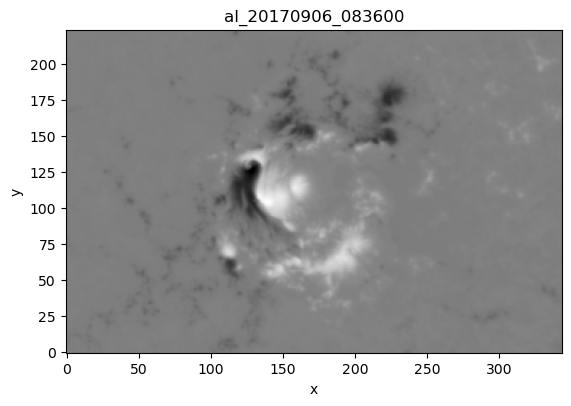

In [ ]:
b_potential_list = sorted(glob.glob(os.path.join(b_potential_paths, '*.vtk')))

fig, ax = plt.subplots()

def update(frame_number):
    ax.cla()
    ax.set_xlabel('x')
    ax.set_ylabel('y')

    b_potential_vtk_path = b_potential_list[frame_number]
    b_potential_date = os.path.basename(b_potential_vtk_path)[12:-4]

    b_potential_mesh = pv.read(b_potential_vtk_path)
    b_potential = mag_plotter(b_potential_mesh)

    ax.imshow(b_potential.B[:, :, 0, 2].transpose(), origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
    ax.set_title(b_potential_date)

ani = animation.FuncAnimation(fig, update, frames=len(b_potential_list))
HTML(ani.to_html5_video())

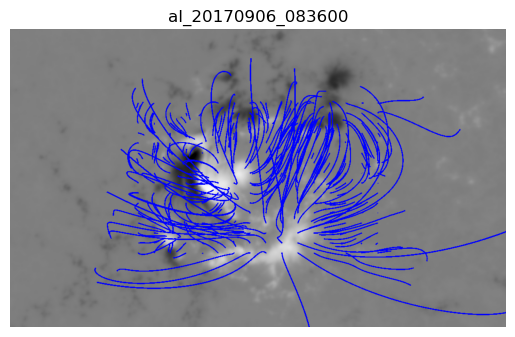

In [ ]:
b_potential_list = sorted(glob.glob(os.path.join(b_potential_paths, '*.vtk')))

fig, ax = plt.subplots()

def update(frame_number):
    ax.cla()
    ax.axis('off')

    b_potential_vtk_path = b_potential_list[frame_number]
    b_potential_date = os.path.basename(b_potential_vtk_path)[12:-4]

    b_potential_mesh = pv.read(b_potential_vtk_path)
    b_potential = mag_plotter(b_potential_mesh)
    b_potential.create_mesh(i_siz=i_siz, j_siz=j_siz, 
                            i_resolution=i_res, j_resolution=j_res,
                            vmin=vmin, vmax=vmax)

    p = pv.Plotter(off_screen=True)
    p.add_mesh(b_potential.grid.outline())
    p.add_mesh(b_potential.bottom, cmap='gray', show_scalar_bar=False, **b_potential.dargs_B)
    p.add_mesh(b_potential.tube, lighting=False, color='blue')
    p.camera_position = 'xy'

    ax.imshow(p.screenshot(scale=2))
    ax.margins(x=-0.25, y=-0.3)
    ax.set_title(b_potential_date)

ani = animation.FuncAnimation(fig, update, frames=len(b_potential_list))
HTML(ani.to_html5_video())